# Imports

In [1]:
import csv

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.constants import physical_constants
from tqdm import tqdm

# Photopic Luminous Efficiency

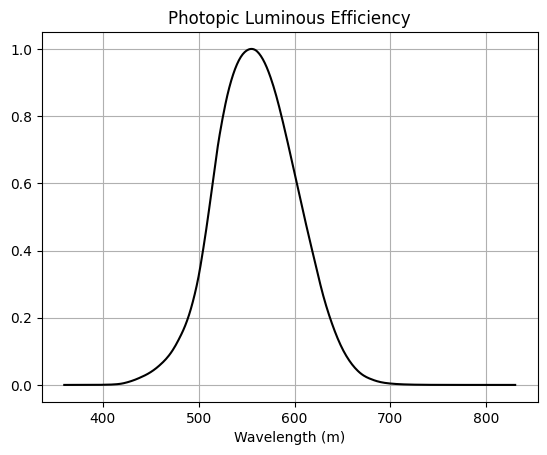

In [2]:
L_list = []
Y_list = []

with open("CIE_sle_photopic.csv", "r") as f:
    reader = csv.reader(f)
    for line in reader:
        L, Y = line
        L_list.append(float(L))
        Y_list.append(float(Y))
        
plt.plot(L_list, Y_list, color='k')
plt.grid()
plt.xlabel("Wavelength (m)")
plt.title("Photopic Luminous Efficiency")
plt.show()

# XYZ Color Space

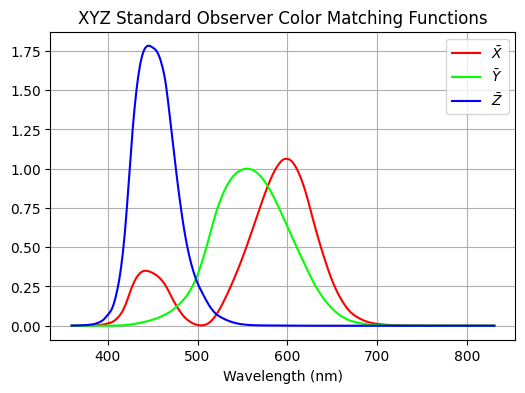

In [3]:
L_list = []
X_list = []
Y_list = []
Z_list = []

with open("CIE_xyz_1931_2deg.csv", "r") as f:
    reader = csv.reader(f)
    for line in reader:
        L, X, Y, Z = line
        L_list.append(float(L))
        X_list.append(float(X))
        Y_list.append(float(Y))
        Z_list.append(float(Z))

L_list = np.array(L_list)
X_list = np.array(X_list)
Y_list = np.array(Y_list)
Z_list = np.array(Z_list)

fig, ax_XYZ = plt.subplots(1, 1, figsize=(6*1, 4*1), sharex=False)
ax_XYZ.plot(L_list, X_list, color=(1, 0, 0), label=r'$\bar{X}$')
ax_XYZ.plot(L_list, Y_list, color=(0, 1, 0), label=r'$\bar{Y}$')
ax_XYZ.plot(L_list, Z_list, color=(0, 0, 1), label=r'$\bar{Z}$')
ax_XYZ.grid()
ax_XYZ.legend()
ax_XYZ.set_xlabel('Wavelength (nm)')
ax_XYZ.set_title('XYZ Standard Observer Color Matching Functions')

plt.show()

# xyY Color Space

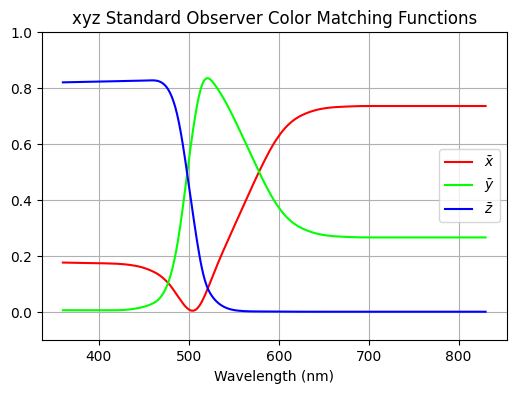

In [4]:
def XYZ_to_xyz(X, Y, Z):
    W = X + Y + Z
    x = X / W
    y = Y / W
    z = Z / W
    return x, y, z


def XYZ_to_xyY(X, Y, Z):
    x, y, _ = XYZ_to_xyz(X, Y, Z)
    return x, y, Y


def xyY_to_XYZ(x, y, Y):
    z = 1 - x - y
    W = Y / y
    X = x * W
    Z = z * W
    return X, Y, Z


x_list, y_list, z_list = XYZ_to_xyz(X_list, Y_list, Z_list)

fig, ax_xyz = plt.subplots(1, 1, figsize=(6*1, 4*1), sharex=False)

ax_xyz.plot(L_list, x_list, color=(1, 0, 0), label=r'$\bar{x}$')
ax_xyz.plot(L_list, y_list, color=(0, 1, 0), label=r'$\bar{y}$')
ax_xyz.plot(L_list, z_list, color=(0, 0, 1), label=r'$\bar{z}$')
ax_xyz.set_title('xyz Standard Observer Color Matching Functions')
ax_xyz.grid()
ax_xyz.legend()
ax_xyz.set_xlabel('Wavelength (nm)')
ax_xyz.set_ylim(-0.1, 1)

plt.show()

# RGB Color Space

In [5]:
R_XYZ = (0.4124, 0.2126, 0.0193) 
G_XYZ = (0.3576, 0.7152, 0.1192) 
B_XYZ = (0.1805, 0.0722, 0.9505) 

RGB_to_XYZ_mat = np.column_stack((R_XYZ, G_XYZ, B_XYZ))
print(RGB_to_XYZ_mat)

XYZ_to_RGB_mat = np.linalg.inv(RGB_to_XYZ_mat)
print(XYZ_to_RGB_mat)

def XYZ_to_RGB(X, Y, Z):
    XYZ = np.array([X, Y, Z])
    return tuple(XYZ_to_RGB_mat @ XYZ)

def RGB_to_XYZ(R, G, B):
    RGB = np.array([R, G, B])
    return tuple(RGB_to_XYZ_mat @ RGB)

def RGB_to_xyY(R, G, B):
    return XYZ_to_xyY(*RGB_to_XYZ(R, G, B))

[[0.4124 0.3576 0.1805]
 [0.2126 0.7152 0.0722]
 [0.0193 0.1192 0.9505]]
[[ 3.24062548 -1.53720797 -0.4986286 ]
 [-0.96893071  1.87575606  0.04151752]
 [ 0.05571012 -0.20402105  1.05699594]]


# sRGB Color Space

In [6]:
U = 0.04045
V = 0.0031308
A = 12.92
C = 0.055
Gamma = 2.4


def gamma_decode(u):
    if u <= U:
        return u/A
    else:
        return ((u + C) / (1 + C))**Gamma


def gamma_encode(v):
    if v <= V:
        return A * v
    else:
        return (1 + C) * v**(1/Gamma) - C


def RGB_to_sRGB(R, G, B):
    sR = gamma_encode(R)
    sG = gamma_encode(G)
    sB = gamma_encode(B)
    return sR, sG, sB


def sRGB_to_RGB(sR, sG, sB):
    R = gamma_decode(sR)
    G = gamma_decode(sG)
    B = gamma_decode(sB)
    return R, G, B


def XYZ_to_sRGB(X, Y, Z):
    RGB = XYZ_to_RGB(X, Y, Z)
    return RGB_to_sRGB(*RGB)


def xyY_to_sRGB(x, y, Y):
    XYZ = xyY_to_XYZ(x, y, Y)
    return XYZ_to_sRGB(*XYZ)

def xy_to_rescaled_sRGB(x, y, max_sRGB_val=1):    
    XYZ = xyY_to_XYZ(x, y, 1)
    R, G, B = XYZ_to_RGB(*XYZ)

    max_RGB_val = gamma_decode(max_sRGB_val)
    rescale_factor = max_sRGB_val / max(R, G, B)
    
    R *= rescale_factor
    G *= rescale_factor
    B *= rescale_factor
    
    sR, sG, sB = RGB_to_sRGB(R, G, B)

    return sR, sG, sB


# Visible Gamut Boundary Check

In [7]:
def xy_in_vis_gamut(x, y):
    if x <= min(x_list):
        return False
    if x >= max(x_list):
        return False

    x_turnover_idx = np.argmin(x_list)
        
    # Upper Boundary, Greens to Reds
    x_seg_upper = x_list[x_turnover_idx:-1] 
    y_seg_upper = y_list[x_turnover_idx:-1] 
    interp_upper = interp1d(x_seg_upper, y_seg_upper)

    y_max = interp_upper(x)
    if y >= y_max:
        return False

    # Lower Boundary, Depends on x value
    if x <= x_list[0]:
        # Blues to Green
        x_seg_lower = x_list[0:x_turnover_idx+1]
        y_seg_lower = y_list[0:x_turnover_idx+1] 
    else:
        # Line of Purples
        x_seg_lower = np.linspace(x_list[0], x_list[-1], 3)
        y_seg_lower = np.linspace(y_list[0], y_list[-1], 3) 
        
    interp_lower = interp1d(x_seg_lower, y_seg_lower)
    y_min = interp_lower(x)
    if y <= y_min:
        return False
    
    return True

# sRGB Gamut Check

In [8]:
R_xy = np.array(RGB_to_xyY(1, 0, 0)[0:2])
G_xy = np.array(RGB_to_xyY(0, 1, 0)[0:2])
B_xy = np.array(RGB_to_xyY(0, 0, 1)[0:2])


def xy_in_sRGB_gamut(x, y):
    if x <= B_xy[0]:
        return False

    if x >= R_xy[0]:
        return False

    # Lower bound: Blues to Reds
    x_seg_lower = np.linspace(B_xy[0], R_xy[0], 3)
    y_seg_lower = np.linspace(B_xy[1], R_xy[1], 3)
    interp_lower = interp1d(x_seg_lower, y_seg_lower)
    y_min = interp_lower(x)
    if y <= y_min:
        return False
    
    if x <= G_xy[0]:
        # Blue to Green
        x_seg_upper = np.linspace(B_xy[0], G_xy[0], 3)
        y_seg_upper = np.linspace(B_xy[1], G_xy[1], 3)
    else:
        # Red to Green
        x_seg_upper = np.linspace(R_xy[0], G_xy[0], 3)
        y_seg_upper = np.linspace(R_xy[1], G_xy[1], 3)     
    interp_upper = interp1d(x_seg_upper, y_seg_upper)
    y_max = interp_upper(x)
    
    if y >= y_max:
        return False
    
    return True

# Project Points into sRGB 
We may want to color (x, y) points outside the sRGB gamut. To do this we will project the points into the sRGB Gamut by drawing a line from the point to the sRGB white point and getting the (x, y) coordinates where the line intersects the triangular boundary of the sRGB gamut.

In [9]:
def cross(v0, v1):
    return v0[0] * v1[1] - v1[0] * v0[1]


def is_triangle_ccw(p0, p1, p2):
    v0 = (p1[0] - p0[0], p1[1] - p0[1])
    v1 = (p2[0] - p0[0], p2[1] - p0[1])
    c = cross(v0, v1)
    if c == 0:
        raise ValueError('Degenerate Triangle')
    return cross(v0, v1) > 0


def do_line_segments_intersect(line0, line1):
    p0, p1, = line0
    p2, p3 = line1
    
    t0_parity = is_triangle_ccw(p0, p2, p3)
    t1_parity = is_triangle_ccw(p1, p2, p3)
    if t0_parity == t1_parity:
        return False

    t2_parity = is_triangle_ccw(p0, p1, p2)
    t3_parity = is_triangle_ccw(p0, p1, p3)
    if t2_parity == t3_parity:
        return False

    return True


def get_intersection_point(line0, line1):
    """
    Copied and slightly modified from https://stackoverflow.com/a/20677983/10466809
    """
    if not do_line_segments_intersect(line0, line1):
        raise Exception('lines do not intersect')

    xdiff = (line0[0][0] - line0[1][0], line1[0][0] - line1[1][0])
    ydiff = (line0[0][1] - line0[1][1], line1[0][1] - line1[1][1])

    div = cross(xdiff, ydiff)
    
    d = (cross(*line0), cross(*line1))
    x = cross(d, xdiff) / div
    y = cross(d, ydiff) / div
    return x, y


W_xy = np.array(RGB_to_xyY(1, 1, 1)[0:2])


def get_projected_xy_in_sRGB(x, y):
    if xy_in_sRGB_gamut(x, y):
        return x, y

    xy = np.array((x, y))
        
    line_xy = (W_xy, xy)
    line_RG = ((R_xy[0], R_xy[1]), (G_xy[0], G_xy[1]))
    line_GB = ((G_xy[0], G_xy[1]), (B_xy[0], B_xy[1]))
    line_BR = ((B_xy[0], B_xy[1]), (R_xy[0], R_xy[1]))
    if do_line_segments_intersect(line_xy, line_RG):
        intersection_point = get_intersection_point(line_xy, line_RG)
    elif do_line_segments_intersect(line_xy, line_GB):
        intersection_point = get_intersection_point(line_xy, line_GB)
    elif do_line_segments_intersect(line_xy, line_BR):
        intersection_point = get_intersection_point(line_xy, line_BR)        
    else:
        raise ValueError('so bad')
    return W_xy + (intersection_point - W_xy)*0.99
    

# Plotting Utilities

In [10]:
def add_line_to_ax(vertex_0, vertex_1, ax, **kwargs):
    x_list = np.linspace(vertex_0[0], vertex_1[0], 3, endpoint=True)
    y_list = np.linspace(vertex_0[1], vertex_1[1], 3, endpoint=True)
    ax.plot(x_list, y_list, **kwargs)
    return ax


def add_tick_to_curve(t_tick, t_list, x_list, y_list, tick_width, ax, **tick_kwargs):
    x_interp = interp1d(t_list, x_list)
    y_interp = interp1d(t_list, y_list)

    # x, y point where the tick is located
    xy = np.array((x_interp(t_tick), y_interp(t_tick)))

    # Velocity where the tick is located
    vx_list = np.gradient(x_list) / np.gradient(t_list)
    vy_list = np.gradient(y_list) / np.gradient(t_list)
    vx = interp1d(t_list, vx_list)(t_tick)
    vy = interp1d(t_list, vy_list)(t_tick)
    v = np.array((vx, vy))

    # Get a vector orthogonal to the velocity
    v_norm = v / np.sqrt(v@v)
    norm_orth = np.array((v_norm[1], -v_norm[0]))

    # Add the tick line to the axis
    ax = add_line_to_ax(
        xy - tick_width*norm_orth, 
        xy + tick_width*norm_orth, 
        ax, 
        **tick_kwargs,
    )
    return ax


def add_ticks_to_curve(t_ticks, major_ticks, tick_label_dict, t_list, x_list, y_list, minor_width, major_width, ax, **tick_kwargs):
    x_interp = interp1d(t_list, x_list)
    y_interp = interp1d(t_list, y_list)
    for t_tick in t_ticks:
        xy = np.array((x_interp(t_tick), y_interp(t_tick)))               
        if t_tick in major_ticks:
            tick_width = major_width
            if t_tick in tick_label_dict:
                text, offset_x, offset_y, text_kwargs = tick_label_dict[t_tick]
                offset = np.array([offset_x, offset_y])
                text_xy = xy + offset
                ax.text(text_xy[0], text_xy[1], text, **text_kwargs)                
        else:
            tick_width = minor_width
        ax = add_tick_to_curve(t_tick, t_list, x_list, y_list, tick_width, ax, **tick_kwargs)
    return ax


# Blackbody Color

In [11]:
def spectrum_to_XYZ(lambda_list, spectrum_list):
    spectrum_interp = interp1d(lambda_list, spectrum_list)
    X = sum(spectrum_interp(L_list) * X_list * np.mean(np.gradient(L_list)))
    Y = sum(spectrum_interp(L_list) * Y_list * np.mean(np.gradient(L_list)))
    Z = sum(spectrum_interp(L_list) * Z_list * np.mean(np.gradient(L_list)))
    return X, Y, Z
    

c = physical_constants['speed of light in vacuum'][0]
h = physical_constants['Planck constant'][0]
kb = physical_constants['Boltzmann constant'][0]


def blackbody_spectrum(wavelength_nm, temp_K):
    T = temp_K
    lam_m = wavelength_nm * 1e-9
    return (2*h*c**2/lam_m**5) * 1/(np.exp(h*c/(lam_m*kb*T)) - 1)


def blackbody_XYZ(temp_K):
    spectrum = blackbody_spectrum(np.array(L_list), temp_K)
    return spectrum_to_XYZ(L_list, spectrum)


def blackbody_xyY(temp_K):
    return XYZ_to_xyY(*blackbody_XYZ(temp_K))

# Plot the Gamut!

## Plot Options

In [87]:
n_steps = 300
use_fixed_luminance = False
color_outside_sRGB_gamut = True

# For use_fixed_luminance = True
fixed_luminance_value = 0.07
fixed_luminance_darker_value = 0.03

# For use_fixed_luminance = False
max_srgb_value = 1
max_srgb_darker_value = 0.5

# For color_outside_sRGB_gamut = False
outside_sRGB_gamute_fixed_sRGB = (0.5, 0.5, 0.5)

greyscale = False

## Plot

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:22<00:00, 13.48it/s]


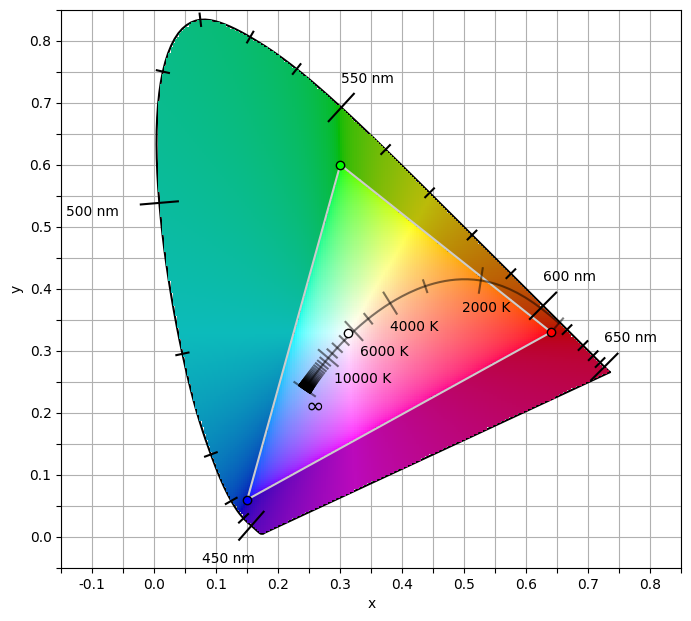

In [88]:
"""
Create the Figure
"""
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

"""
Visible Gamut curve and wavelength ticks
"""
ax.plot(x_list, y_list, marker='', linestyle='-', color='k', zorder=2.1)

# Custom tick offsets to make the labels look good
L_tick_offsets = {
    450: ("450 nm", -0.08, -0.06, {}),
    500: ("500 nm", -0.15, -0.02, {}),
    550: ("550 nm", +0.00, +0.04, {}),
    600: ("600 nm", +0.00, +0.04, {}),
    650: ("650 nm", +0.00, +0.04, {}),
}
add_ticks_to_curve(np.arange(450, 651, 10), [450, 500, 550, 600, 650], L_tick_offsets, L_list, x_list, y_list, 0.01, 0.03, ax, color='k', zorder=2.3)

"""
Line of Purples
"""
blue_terminus = (x_list[0], y_list[0])
red_terminus = (x_list[-1], y_list[-1])
add_line_to_ax(blue_terminus, red_terminus, ax, marker='', linestyle='-', color='k', zorder=2.1)

"""
Points for the 3 sRGB primaries
"""
ax.plot(R_xy[0], R_xy[1], color=(1, 0, 0), marker='o', markeredgecolor='k', zorder=2.3)
ax.plot(G_xy[0], G_xy[1], color=(0, 1, 0), marker='o', markeredgecolor='k', zorder=2.3)
ax.plot(B_xy[0], B_xy[1], color=(0, 0, 1), marker='o', markeredgecolor='k', zorder=2.3)

"""
Point for the White D65 point
"""
ax.plot(W_xy[0], W_xy[1], color=(1, 1, 1), marker='o', markeredgecolor='k', zorder=2.3)

"""
The sRGB Gamut Triangle
"""
add_line_to_ax(R_xy, G_xy, ax, color=(0.8, 0.8, 0.8), zorder=2.29)
add_line_to_ax(G_xy, B_xy, ax, color=(0.8, 0.8, 0.8), zorder=2.29)
add_line_to_ax(B_xy, R_xy, ax, color=(0.8, 0.8, 0.8), zorder=2.29)

"""
xy grid for coloring
"""
x_array = np.linspace(0, 1, n_steps)
y_array = np.linspace(0, 1, n_steps)
color_array = np.zeros((n_steps, n_steps, 4))

"""
Color in the Gamut
"""
for x_idx, x in enumerate(tqdm(x_array)):
    for y_idx, y in enumerate(y_array):

        if xy_in_sRGB_gamut(x, y):
            if use_fixed_luminance:
                sRGB = xyY_to_sRGB(x, y, fixed_luminance_value)
            else:
                sRGB = xy_to_rescaled_sRGB(x, y, max_srgb_value)
            a = 1
        elif xy_in_vis_gamut(x, y):
            if color_outside_sRGB_gamut:
                closest_x, closest_y = get_projected_xy_in_sRGB(x, y)                    
                if use_fixed_luminance:
                    sRGB = xyY_to_sRGB(closest_x, closest_y, fixed_luminance_darker_value)
                else:
                    sRGB = xy_to_rescaled_sRGB(closest_x, closest_y, max_srgb_darker_value)
            else:
                sRGB = outside_sRGB_gamute_fixed_sRGB
            a = 1
        else:
            sRGB = (0, 0, 1)
            a = 0

        if greyscale:
            RGB = sRGB_to_RGB(*sRGB)
            _, Y, _ = RGB_to_XYZ(*RGB)
            sRGB = xyY_to_sRGB(W_xy[0], W_xy[1], Y)
        
        sR, sG, sB = sRGB
        color_array[y_idx, x_idx, :] = sRGB + (a,)

ax.imshow(color_array, extent=(0, 1, 0, 1), origin='lower', zorder=2.1, interpolation='none')

"""
Add the Planckian Locus
"""
temp_list = np.arange(1e3, 100e3+1, 100)
temp_x_list = []
temp_y_list = []
for temp in temp_list:
    x, y, _ = blackbody_xyY(temp)
    temp_x_list.append(x)
    temp_y_list.append(y)
ax.plot(temp_x_list, temp_y_list, color='k', zorder=2.29, alpha=0.5)

planck_tick_dict = {
    2000: ('2000 K', -0.03, -0.05, {}),
    4000: ('4000 K', -0.00, -0.045, {}),
    6000: ('6000 K', +0.01, -0.04, {}),
    10000: ('10000 K', +0.01, -0.04, {}),
    100000: (r'$\infty$', 0, -0.035, {'fontsize': 16}),
}
temp_ticks = np.arange(1e3, 100e3+1, 1000)
temp_major_ticks = [2000, 4000, 6000, 10000, 100000]
temp_major_ticks = list(temp_major_ticks) + [100e3]
add_ticks_to_curve(temp_ticks, temp_major_ticks, planck_tick_dict, temp_list, temp_x_list, temp_y_list, 0.01, 0.02, ax, color='k', zorder=2.29, alpha=0.5)

"""
x and y axis ticks and labels
"""
ax_ticks = np.arange(-2, 2, 0.05)
ax_tick_labels = []
for ax_tick in ax_ticks:
    if np.isclose(ax_tick % 0.1, 0):
        ax_tick_label = f'{ax_tick:.1f}'
    else:
        ax_tick_label = ''
    ax_tick_labels.append(ax_tick_label)
ax.set_xticks(ax_ticks, labels=ax_tick_labels)
ax.set_yticks(ax_ticks, labels=ax_tick_labels)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-0.15, 0.85)
ax.set_ylim(-0.05, 0.85)

ax.grid(which='both')

plt.show()

# Plot the Electromagnetic Spectrum

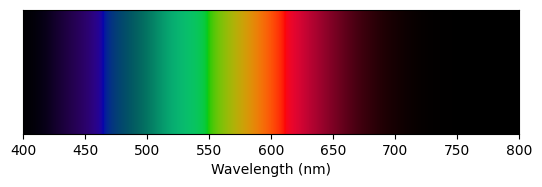

In [91]:
X_interp = interp1d(L_list, X_list)
Y_interp = interp1d(L_list, Y_list)
Z_interp = interp1d(L_list, Z_list)

def monochromatic_to_XYZ(wavelength_nm, scale=1e-3):
    X = scale*X_interp(wavelength_nm)
    Y = scale*Y_interp(wavelength_nm)    
    Z = scale*Z_interp(wavelength_nm)
    return X, Y, Z

fig, ax = plt.subplots(1, 1)

n_x_steps = 300
n_y_steps = 3
color_array = np.zeros((n_y_steps, n_x_steps, 3))
wavelengths = np.linspace(400, 800, n_x_steps)

for x_idx, wavelength in enumerate(wavelengths):
    x, y, Y = XYZ_to_xyY(*monochromatic_to_XYZ(wavelength, scale=0.43))
    new_x, new_y = get_projected_xy_in_sRGB(x, y)
    RGB = xyY_to_sRGB(new_x, new_y, Y)  
    for y_idx in range(n_y_steps):
        color_array[y_idx, x_idx, :] = RGB
ax.imshow(color_array, extent=(min(wavelengths), max(wavelengths), 0, 100))
ax.get_yaxis().set_visible(False)
ax.set_xlabel('Wavelength (nm)')
plt.show()

# Blackbody Curves Vs. Wavelength

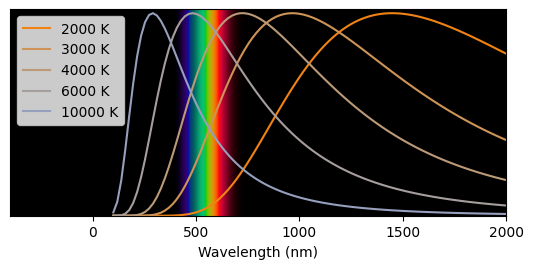

In [101]:
fig, ax = plt.subplots(1, 1)
wavelengths = np.linspace(100, 2000, 100)
ax.imshow(color_array, extent=(400, 800, 0, 1))
for temp in [2000, 3000, 4000, 6000, 10000]:
    spec = blackbody_spectrum(wavelengths, temp)
    x, y, Y = blackbody_xyY(temp)
    # RGB = xy_to_rescaled_sRGB(x, y, 1)
    RGB = xyY_to_sRGB(x, y, 0.35) 
    
    ax.plot(wavelengths, 0.98*spec/max(spec), color=RGB, label=f'{temp} K')
ax.set_xlim(-400, 2000)
# ax.set_ylim(0, 1)
ax.legend()
ax.set_aspect(1000)
ax.get_yaxis().set_visible(False)
ax.set_xlabel('Wavelength (nm)')
ax.set_facecolor('black')
plt.show()

# Color Vs. Blackbody Temperature

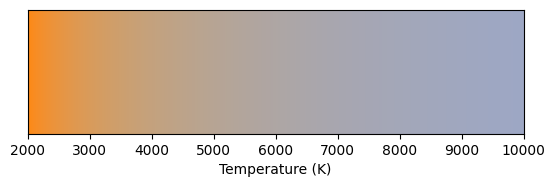

In [102]:
fig, ax = plt.subplots(1, 1)

n_x_steps = 300
n_y_steps = 3
color_array = np.zeros((n_y_steps, n_x_steps, 3))

temps = np.linspace(2000, 10000, n_x_steps)
for x_idx, temp in enumerate(temps):
    x, y, Y = blackbody_xyY(temp)
    new_x, new_y = get_projected_xy_in_sRGB(x, y)
    
    # RGB = xy_to_rescaled_sRGB(new_x, new_y, 1) 
    RGB = xyY_to_sRGB(new_x, new_y, 0.39) 
    # RGB = xyY_to_sRGB(new_x, new_y, Y*3e-17) 
    
    for y_idx in range(n_y_steps):
        color_array[y_idx, x_idx, :] = RGB
ax.imshow(color_array, extent=(min(temps), max(temps), 0, 2000))
ax.get_yaxis().set_visible(False)
ax.set_xlabel('Temperature (K)')
plt.show()